In [8]:
!poetry add scikit-learn
!poetry add seaborn

Using version ^1.3.1 for scikit-learn

Updating dependencies
Resolving dependencies... (4.3s)Resolving dependencies... (0.5s)Resolving dependencies... (2.5s)

Package operations: 0 installs, 1 update, 0 removals

  • Updating sklearn (0.0.post9 -> 0.0.post10): Pending...
  • Updating sklearn (0.0.post9 -> 0.0.post10): Preparing...
  • Updating sklearn (0.0.post9 -> 0.0.post10): Failed

  ChefBuildError

  Backend subprocess exited when trying to invoke get_requires_for_build_wheel
  
  The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
  rather than 'sklearn' for pip commands. 
  
  Here is how to fix this error in the main use cases:
  - use 'pip install scikit-learn' rather than 'pip install sklearn'
  - replace 'sklearn' by 'scikit-learn' in your pip requirements files
    (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
  - if the 'sklearn' package is used by one of your dependencies,
    it would be great if you take some time to track which package uses
    'sk

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("feature_frame.csv").drop(columns="people_ex_baby")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 26 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [4]:
df_sell_prod = df[df["outcome"]==1]

count_sell_products = df_sell_prod.groupby(df_sell_prod.order_id).count().reset_index()

order_list = count_sell_products.order_id[count_sell_products.variant_id>=5].to_list()

df_filter = df[df.order_id.isin(order_list)]


df_work = df_filter.copy()
categorical_cols = ['product_type', 'vendor']
for col in categorical_cols:
    col_frequency = df_filter[col].value_counts() / len(df_filter)
    df_work[f"{col}_encoded"] = df_work[col].map(col_frequency).copy()


df_work.sort_values(["user_id", "order_id", "order_date"], inplace=True)

In [5]:
info_cols = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
label_col = 'outcome'

features_cols = [col for col in df.columns if col not in info_cols + [label_col]]

categorical_cols = ['product_type', 'vendor']
binary_cols = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']
numerical_cols = [col for col in features_cols if col not in categorical_cols + binary_cols]

In [10]:
df_work[numerical_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
user_order_seq,2163953.0,3.414455,2.287832,2.000000,2.000000,3.000000,4.000000,21.000000
normalised_price,2163953.0,0.127129,0.126718,0.015993,0.053944,0.081052,0.135267,1.000000
discount_pct,2163953.0,0.186470,0.193684,-0.040161,0.086331,0.116918,0.223464,1.325301
global_popularity,2163953.0,0.010785,0.016630,0.000000,0.001634,0.006342,0.014329,0.425439
count_adults,2163953.0,2.023446,0.238408,1.000000,2.000000,2.000000,2.000000,5.000000
count_children,2163953.0,0.068752,0.365606,0.000000,0.000000,0.000000,0.000000,3.000000
count_babies,2163953.0,0.004074,0.063702,0.000000,0.000000,0.000000,0.000000,1.000000
count_pets,2163953.0,0.065848,0.341969,0.000000,0.000000,0.000000,0.000000,6.000000
days_since_purchase_variant_id,2163953.0,33.162723,4.094441,0.000000,33.000000,33.000000,33.000000,148.000000
avg_days_to_buy_variant_id,2163953.0,35.293972,10.555183,0.000000,30.000000,34.000000,40.000000,84.000000


In [11]:
df_work[numerical_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2163953 entries, 0 to 2880547
Data columns (total 14 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   user_order_seq                    int64  
 1   normalised_price                  float64
 2   discount_pct                      float64
 3   global_popularity                 float64
 4   count_adults                      float64
 5   count_children                    float64
 6   count_babies                      float64
 7   count_pets                        float64
 8   days_since_purchase_variant_id    float64
 9   avg_days_to_buy_variant_id        float64
 10  std_days_to_buy_variant_id        float64
 11  days_since_purchase_product_type  float64
 12  avg_days_to_buy_product_type      float64
 13  std_days_to_buy_product_type      float64
dtypes: float64(13), int64(1)
memory usage: 247.6 MB


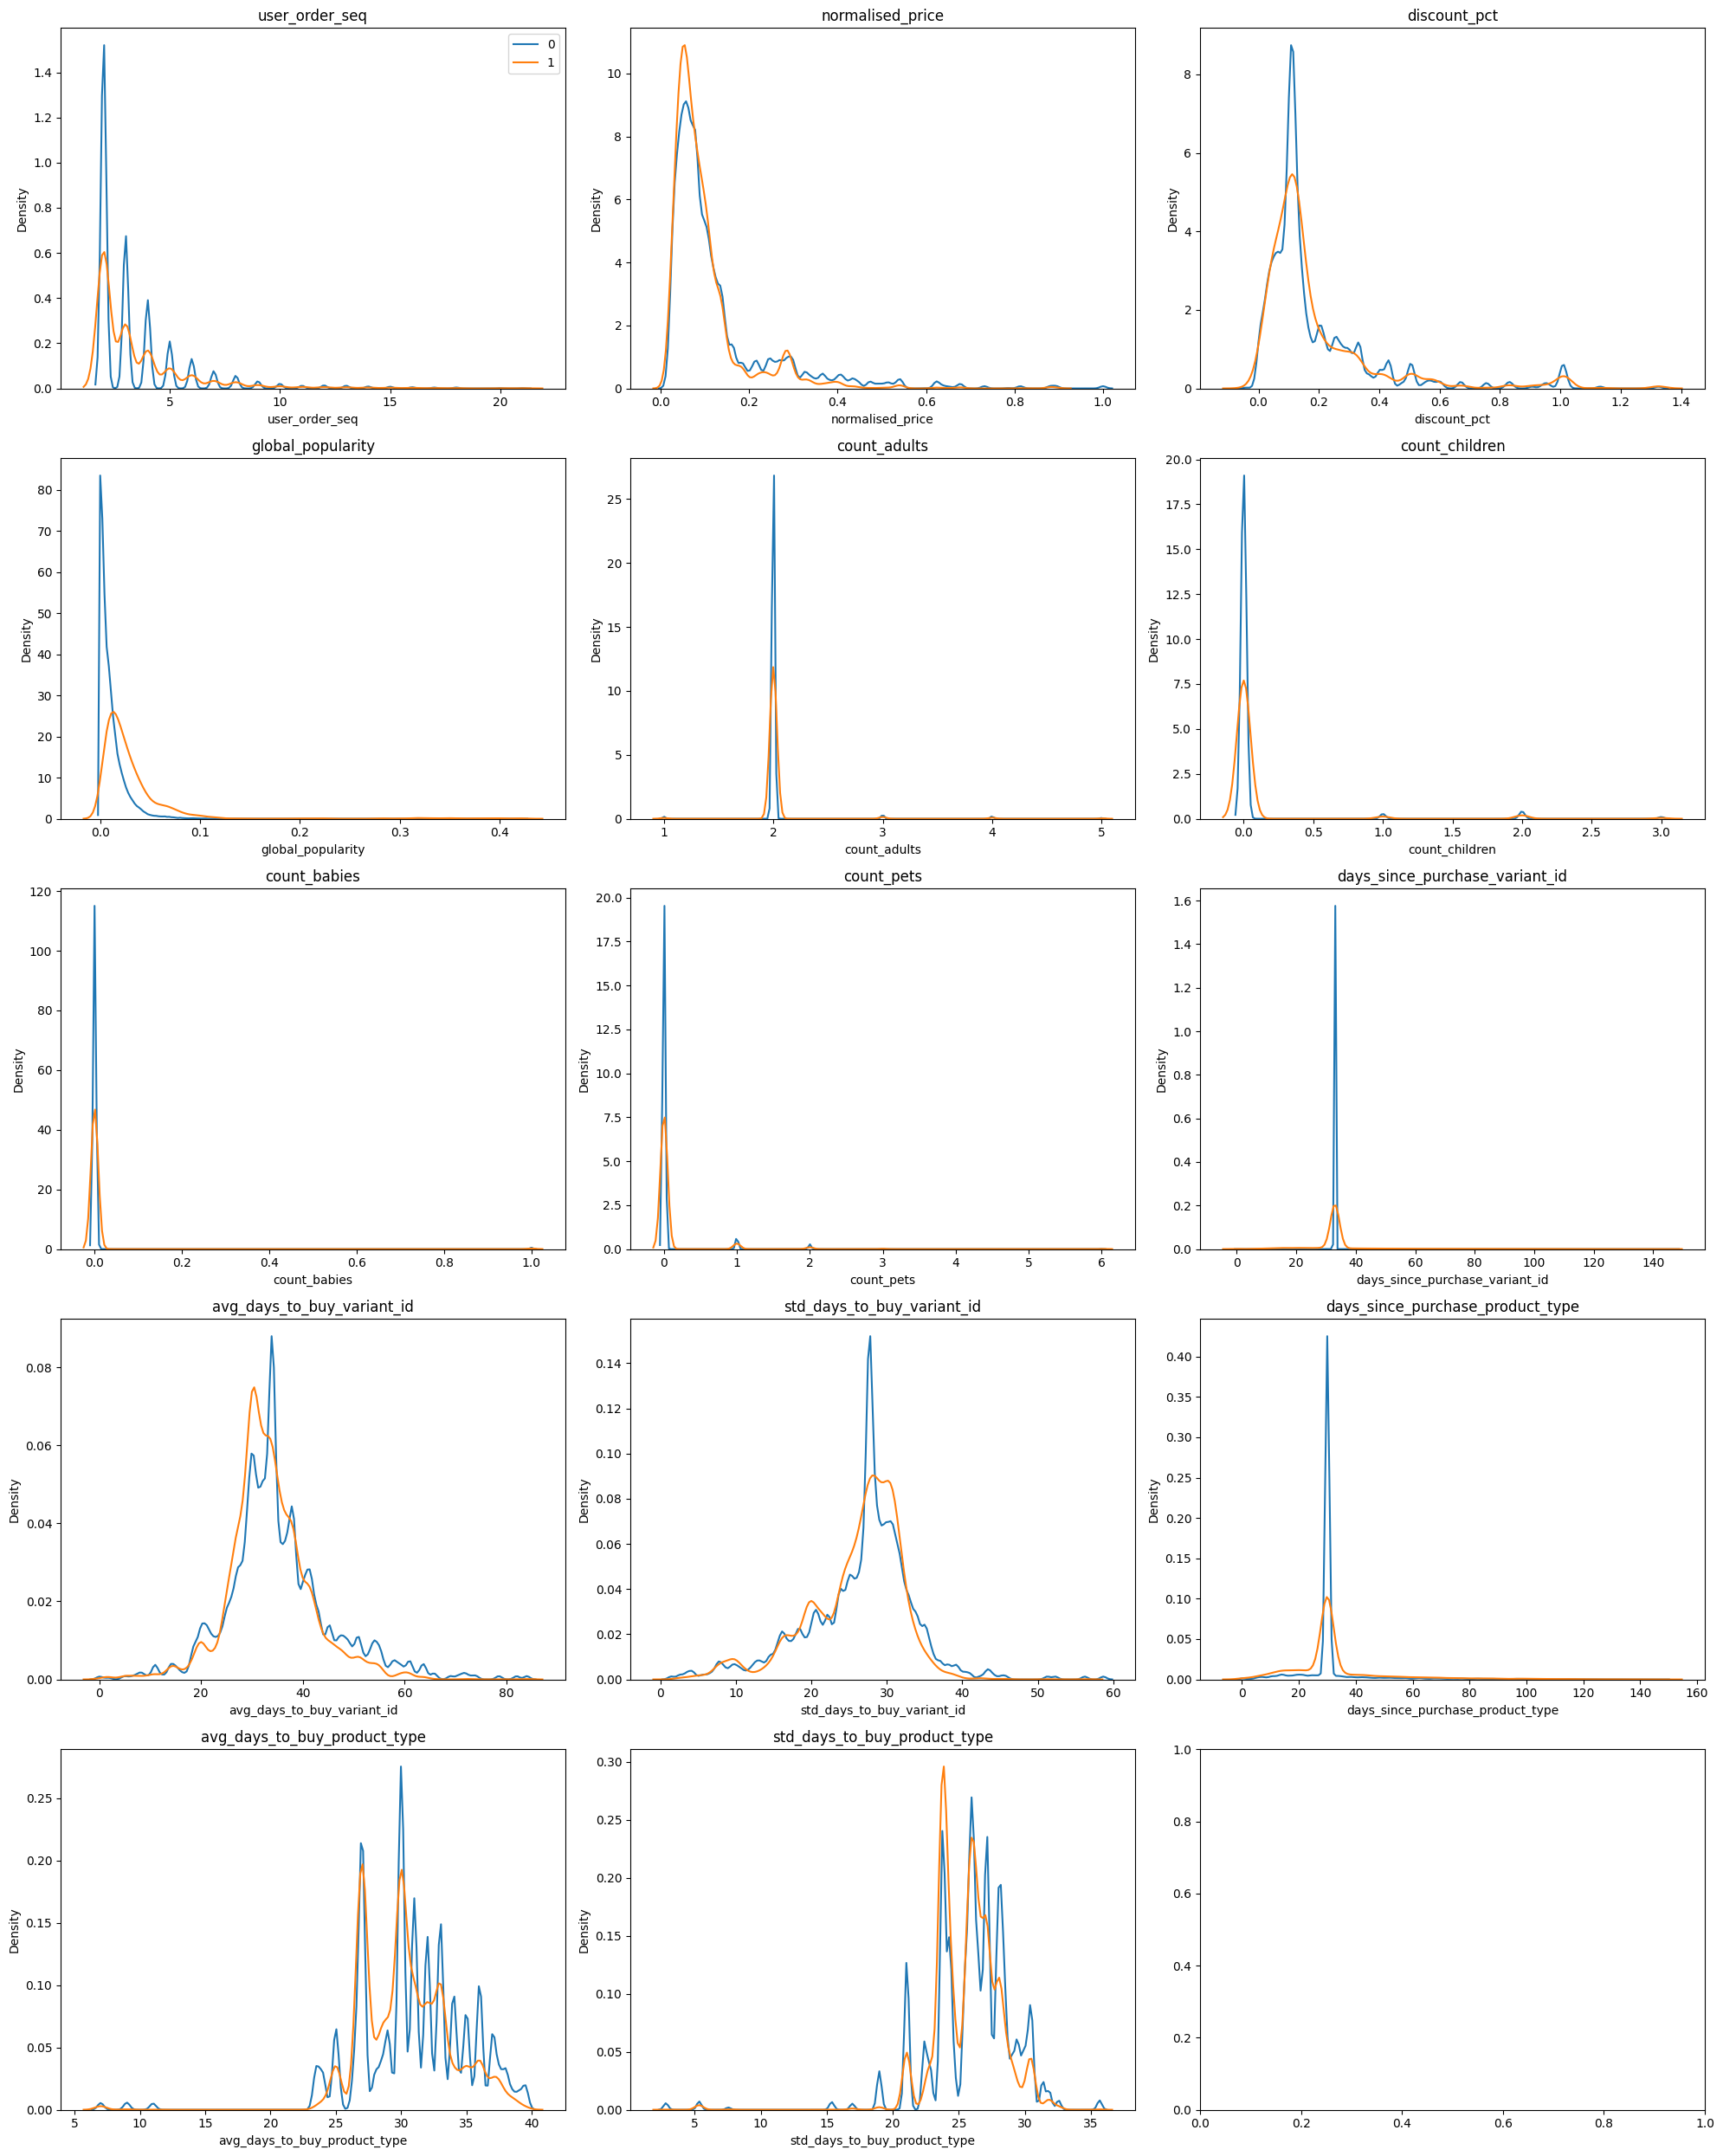

In [12]:
cols = 3
rows = int(np.ceil(len(numerical_cols) / cols))
fig, ax = plt.subplots(rows, cols, figsize=(20, 5*rows))
ax = ax.flatten()

for i, col in enumerate(numerical_cols):
    sns.kdeplot(df_work.loc[lambda x: x.outcome == 0, col], label='0', ax=ax[i])
    sns.kdeplot(df_work.loc[lambda x: x.outcome == 1, col], label='1', ax=ax[i])
    ax[i].set_title(col)
    
ax[0].legend()

plt.tight_layout()

array([[<Axes: title={'center': 'order_id'}>]], dtype=object)

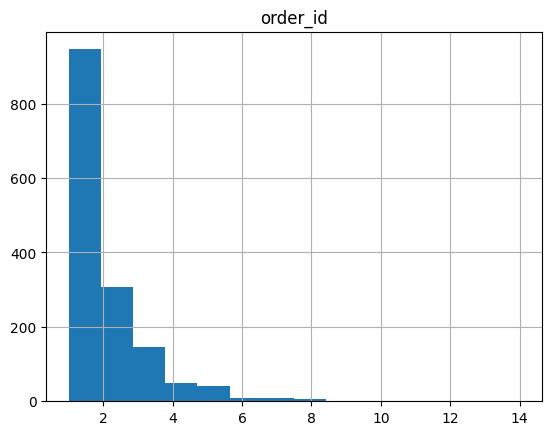

In [21]:
df_work[["user_id", "order_id"]].drop_duplicates().groupby("user_id").count().sort_values(("order_id")).hist(bins=14)

In [7]:


df_work.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_babies,count_pets,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,product_type_encoded,vendor_encoded
1410,33826472919172,ricepastapulses,2889875882116,3046041190532,2021-01-06 19:34:36,2021-01-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,33.0,42.0,31.134053,58.0,30.0,24.276180,0.044619,0.014435
6843,34284951273604,dishwasherdetergent,2889875882116,3046041190532,2021-01-06 19:34:36,2021-01-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,33.0,38.0,31.091048,58.0,32.0,25.841947,0.034212,0.007131
12048,33667302359172,cleaningaccessories,2889875882116,3046041190532,2021-01-06 19:34:36,2021-01-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,33.0,36.0,27.986674,30.0,35.0,29.001400,0.017485,0.001203
15494,33667206283396,fabricconditionerfreshener,2889875882116,3046041190532,2021-01-06 19:34:36,2021-01-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,33.0,48.0,31.431177,30.0,36.0,28.588469,0.014365,0.039429
18555,34368927957124,coffee,2889875882116,3046041190532,2021-01-06 19:34:36,2021-01-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,33.0,33.0,22.013658,30.0,31.0,24.363052,0.020052,0.005069


In [31]:
a = df_work[df_work["outcome"]==1].groupby(["order_id", "user_id"]).count().sort_values(by="variant_id").reset_index()

In [8]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_work, test_size=0.2, random_state=99, stratify=df_work.order_id)

df_test, df_validation = train_test_split(df_test, test_size=0.5, random_state=99, stratify=df_test.order_id)



In [11]:
df_train[df_train["order_id"]==2908345434244]

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_babies,count_pets,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,product_type_encoded,vendor_encoded
1144907,33667254026372,femininecare,2908345434244,3417224708228,2021-01-29 09:42:43,2021-01-29 00:00:00,7,0.0,0.0,0.0,...,0.0,0.0,33.0,41.0,32.331269,74.0,34.0,25.368491,0.018523,0.004812
1298163,33667226173572,dental,2908345434244,3417224708228,2021-01-29 09:42:43,2021-01-29 00:00:00,7,0.0,0.0,0.0,...,0.0,0.0,33.0,30.0,26.508326,74.0,33.0,27.935275,0.022422,0.002406
67574,34457368068228,homebaking,2908345434244,3417224708228,2021-01-29 09:42:43,2021-01-29 00:00:00,7,0.0,0.0,0.0,...,0.0,0.0,33.0,29.0,14.637047,38.0,28.5,23.710730,0.018857,0.001606
987435,34317850411140,snacksconfectionery,2908345434244,3417224708228,2021-01-29 09:42:43,2021-01-29 00:00:00,7,0.0,0.0,0.0,...,0.0,0.0,33.0,27.0,24.868124,30.0,27.0,23.634873,0.022614,0.004546
2056227,34460976808068,nappies,2908345434244,3417224708228,2021-01-29 09:42:43,2021-01-29 00:00:00,7,0.0,0.0,0.0,...,0.0,0.0,33.0,18.5,24.748737,30.0,23.5,21.071762,0.018638,0.006052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1831854,34415987196036,delicatesstainremover,2908345434244,3417224708228,2021-01-29 09:42:43,2021-01-29 00:00:00,7,0.0,0.0,0.0,...,0.0,0.0,33.0,29.0,18.160363,30.0,37.5,30.190500,0.006663,0.004236
1893505,34415985262724,coffee,2908345434244,3417224708228,2021-01-29 09:42:43,2021-01-29 00:00:00,7,0.0,0.0,0.0,...,0.0,0.0,33.0,27.0,18.243068,30.0,31.0,24.363052,0.020052,0.003610
362461,34284954747012,tea,2908345434244,3417224708228,2021-01-29 09:42:43,2021-01-29 00:00:00,7,0.0,0.0,0.0,...,0.0,0.0,33.0,33.0,24.139268,30.0,33.0,26.060328,0.018030,0.001203
2313434,33667281256580,facialskincare,2908345434244,3417224708228,2021-01-29 09:42:43,2021-01-29 00:00:00,7,0.0,0.0,0.0,...,0.0,0.0,33.0,21.0,27.693045,30.0,38.0,28.492200,0.016974,0.005857


In [12]:
df_test[df_test["order_id"]==2908345434244]

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_babies,count_pets,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,product_type_encoded,vendor_encoded
1569141,33826460303492,ricepastapulses,2908345434244,3417224708228,2021-01-29 09:42:43,2021-01-29 00:00:00,7,0.0,0.0,0.0,...,0.0,0.0,33.0,37.5,31.871698,38.0,30.0,24.276180,0.044619,0.024058
810664,33826422620292,ricepastapulses,2908345434244,3417224708228,2021-01-29 09:42:43,2021-01-29 00:00:00,7,0.0,0.0,0.0,...,0.0,0.0,33.0,45.0,26.192849,38.0,30.0,24.276180,0.044619,0.006014
365907,33667207233668,bathroomlimescalecleaner,2908345434244,3417224708228,2021-01-29 09:42:43,2021-01-29 00:00:00,7,0.0,0.0,0.0,...,0.0,0.0,33.0,43.0,30.171354,30.0,33.0,26.873475,0.028845,0.039429
1565695,33667198976132,dishwasherdetergent,2908345434244,3417224708228,2021-01-29 09:42:43,2021-01-29 00:00:00,7,0.0,0.0,0.0,...,0.0,0.0,33.0,44.0,26.891608,30.0,32.0,25.841947,0.034212,0.039429
37987,34370916515972,tinspackagedfoods,2908345434244,3417224708228,2021-01-29 09:42:43,2021-01-29 00:00:00,7,0.0,0.0,0.0,...,0.0,0.0,33.0,30.5,22.851500,38.0,27.0,23.827826,0.078348,0.002246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846999,34037940224132,kitchenrolltissues,2908345434244,3417224708228,2021-01-29 09:42:43,2021-01-29 00:00:00,7,0.0,0.0,0.0,...,0.0,0.0,33.0,29.0,20.800604,38.0,30.0,24.688701,0.011017,0.005007
261924,34276571480196,driedfruitsnutsseeds,2908345434244,3417224708228,2021-01-29 09:42:43,2021-01-29 00:00:00,7,0.0,0.0,0.0,...,0.0,0.0,33.0,29.0,25.880729,105.0,31.0,27.105851,0.015638,0.024058
1357835,33826416754820,cookingingredientsoils,2908345434244,3417224708228,2021-01-29 09:42:43,2021-01-29 00:00:00,7,0.0,0.0,0.0,...,0.0,0.0,33.0,39.0,29.924344,38.0,31.0,27.135844,0.038385,0.002406
2302537,34368926777476,condimentsdressings,2908345434244,3417224708228,2021-01-29 09:42:43,2021-01-29 00:00:00,7,0.0,0.0,0.0,...,0.0,0.0,33.0,29.0,20.053096,38.0,30.0,26.081884,0.045140,0.003451


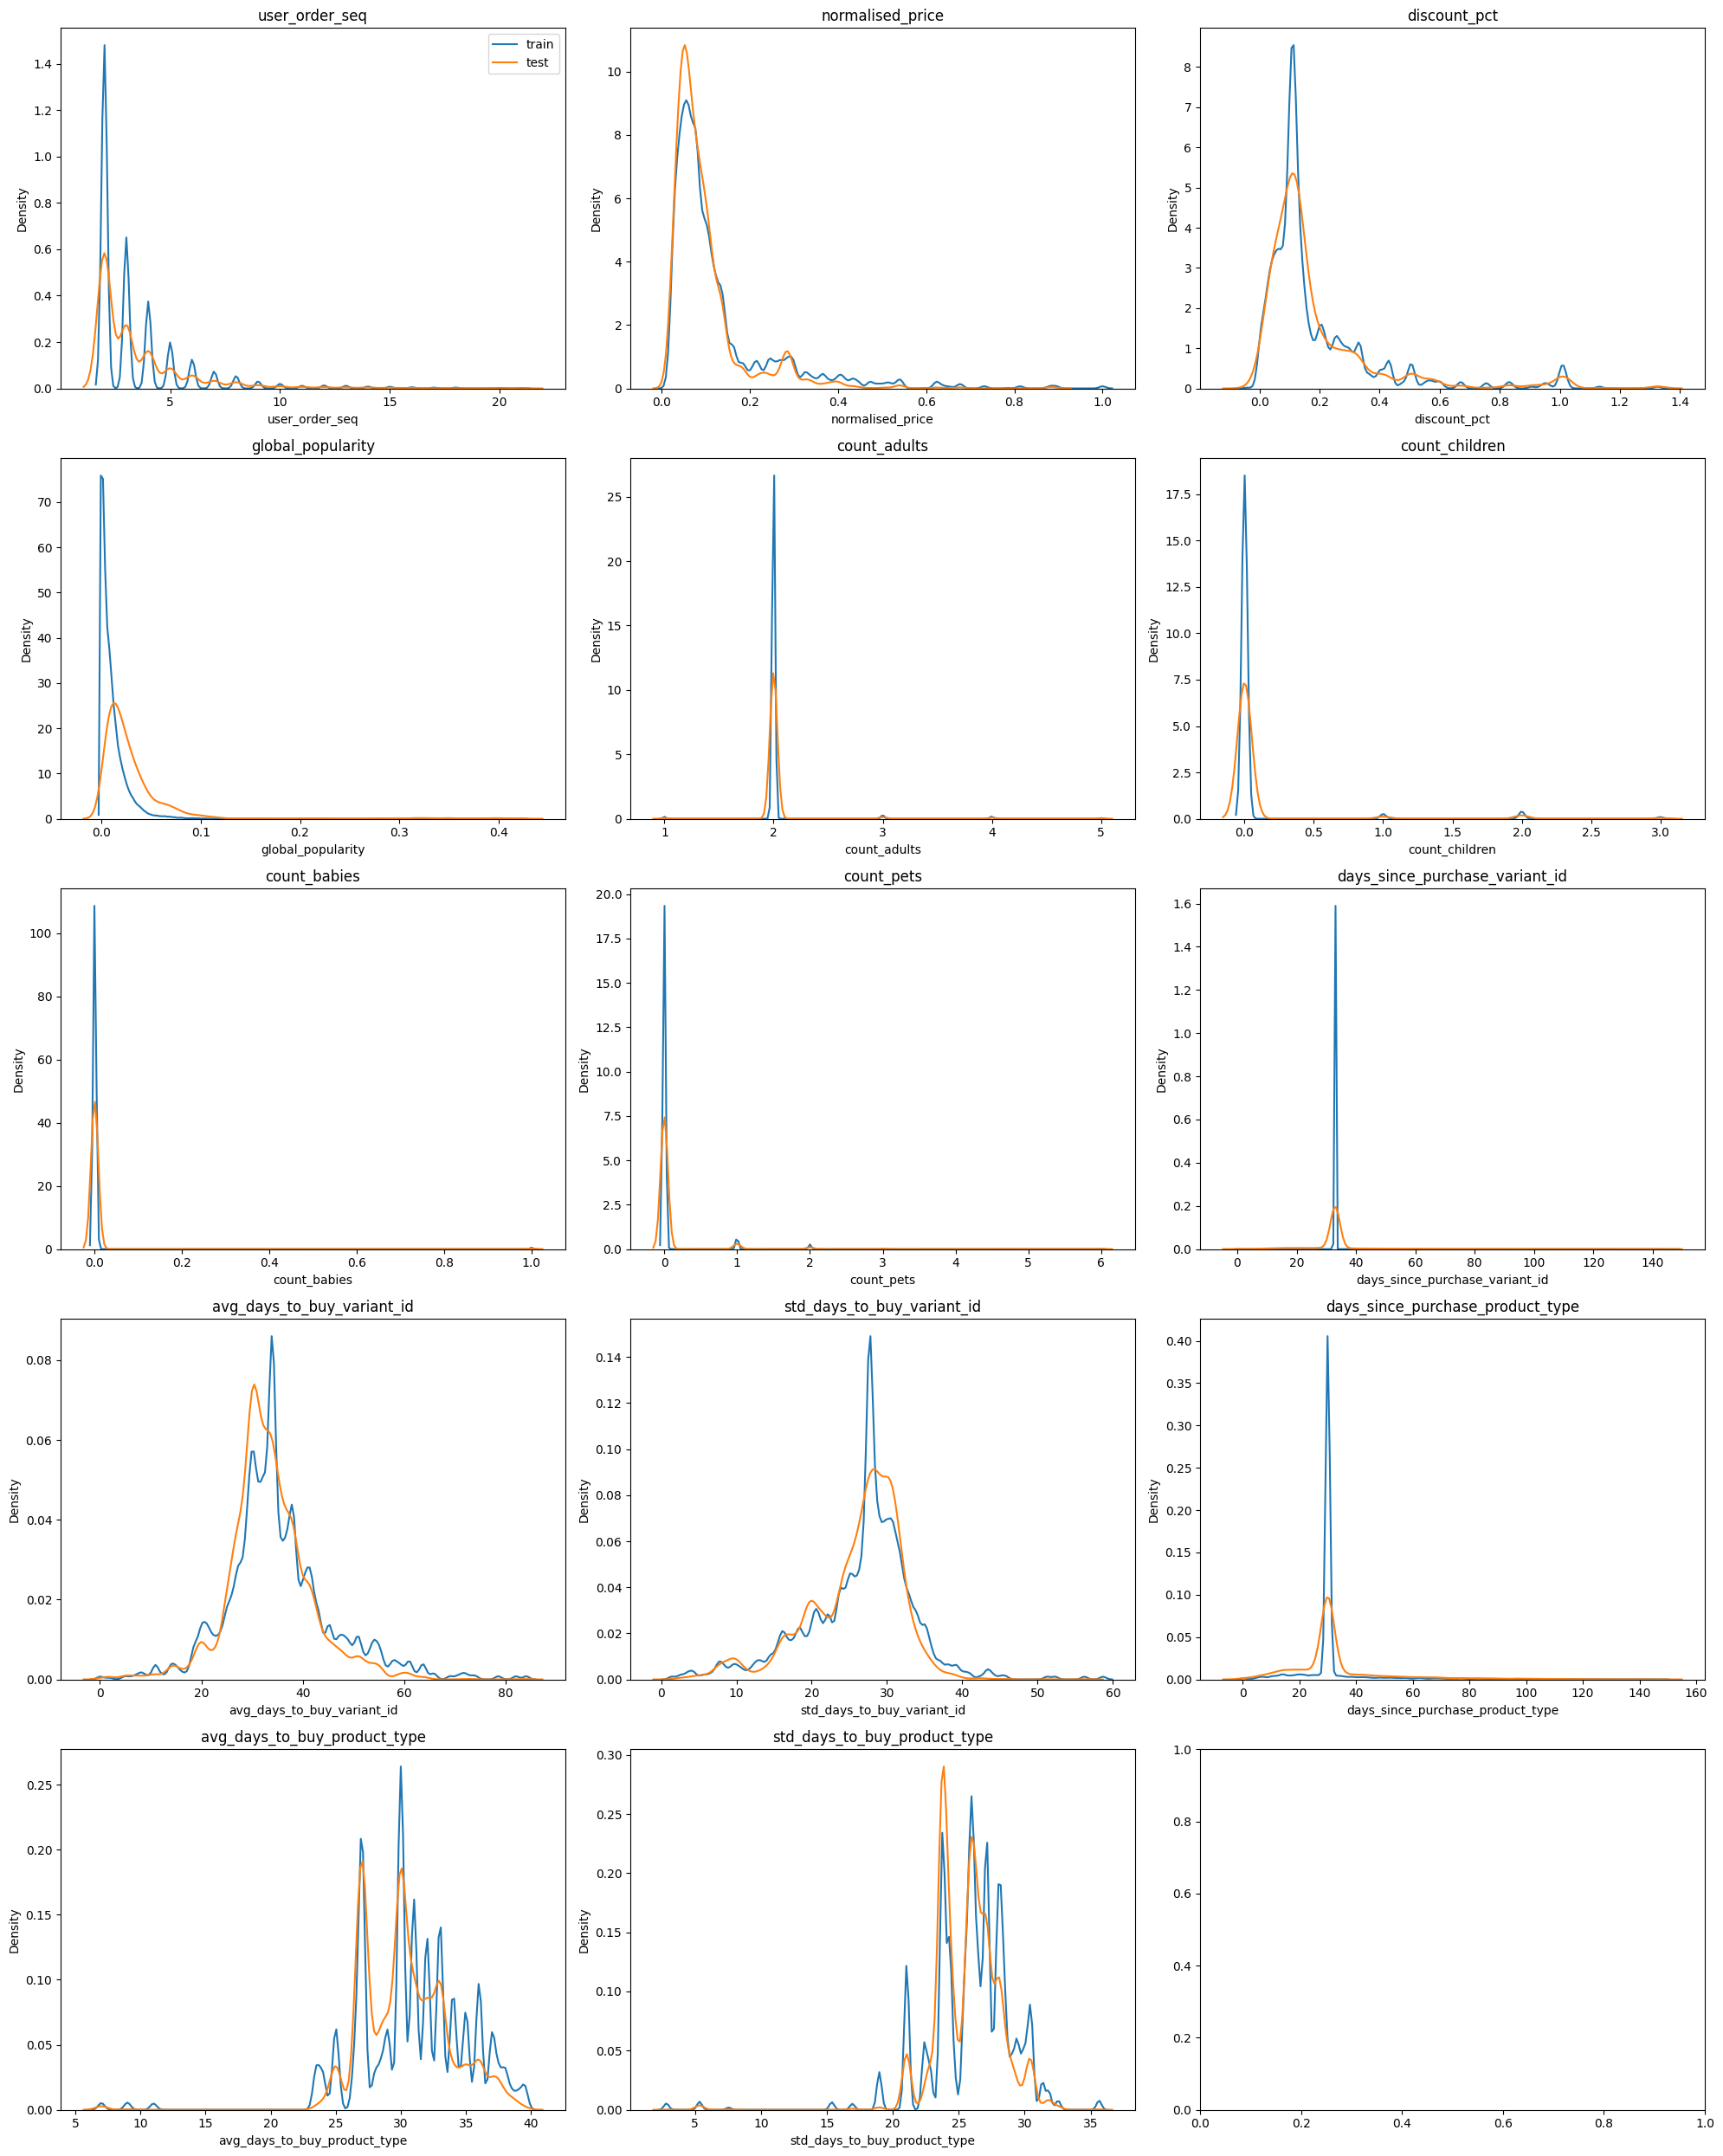

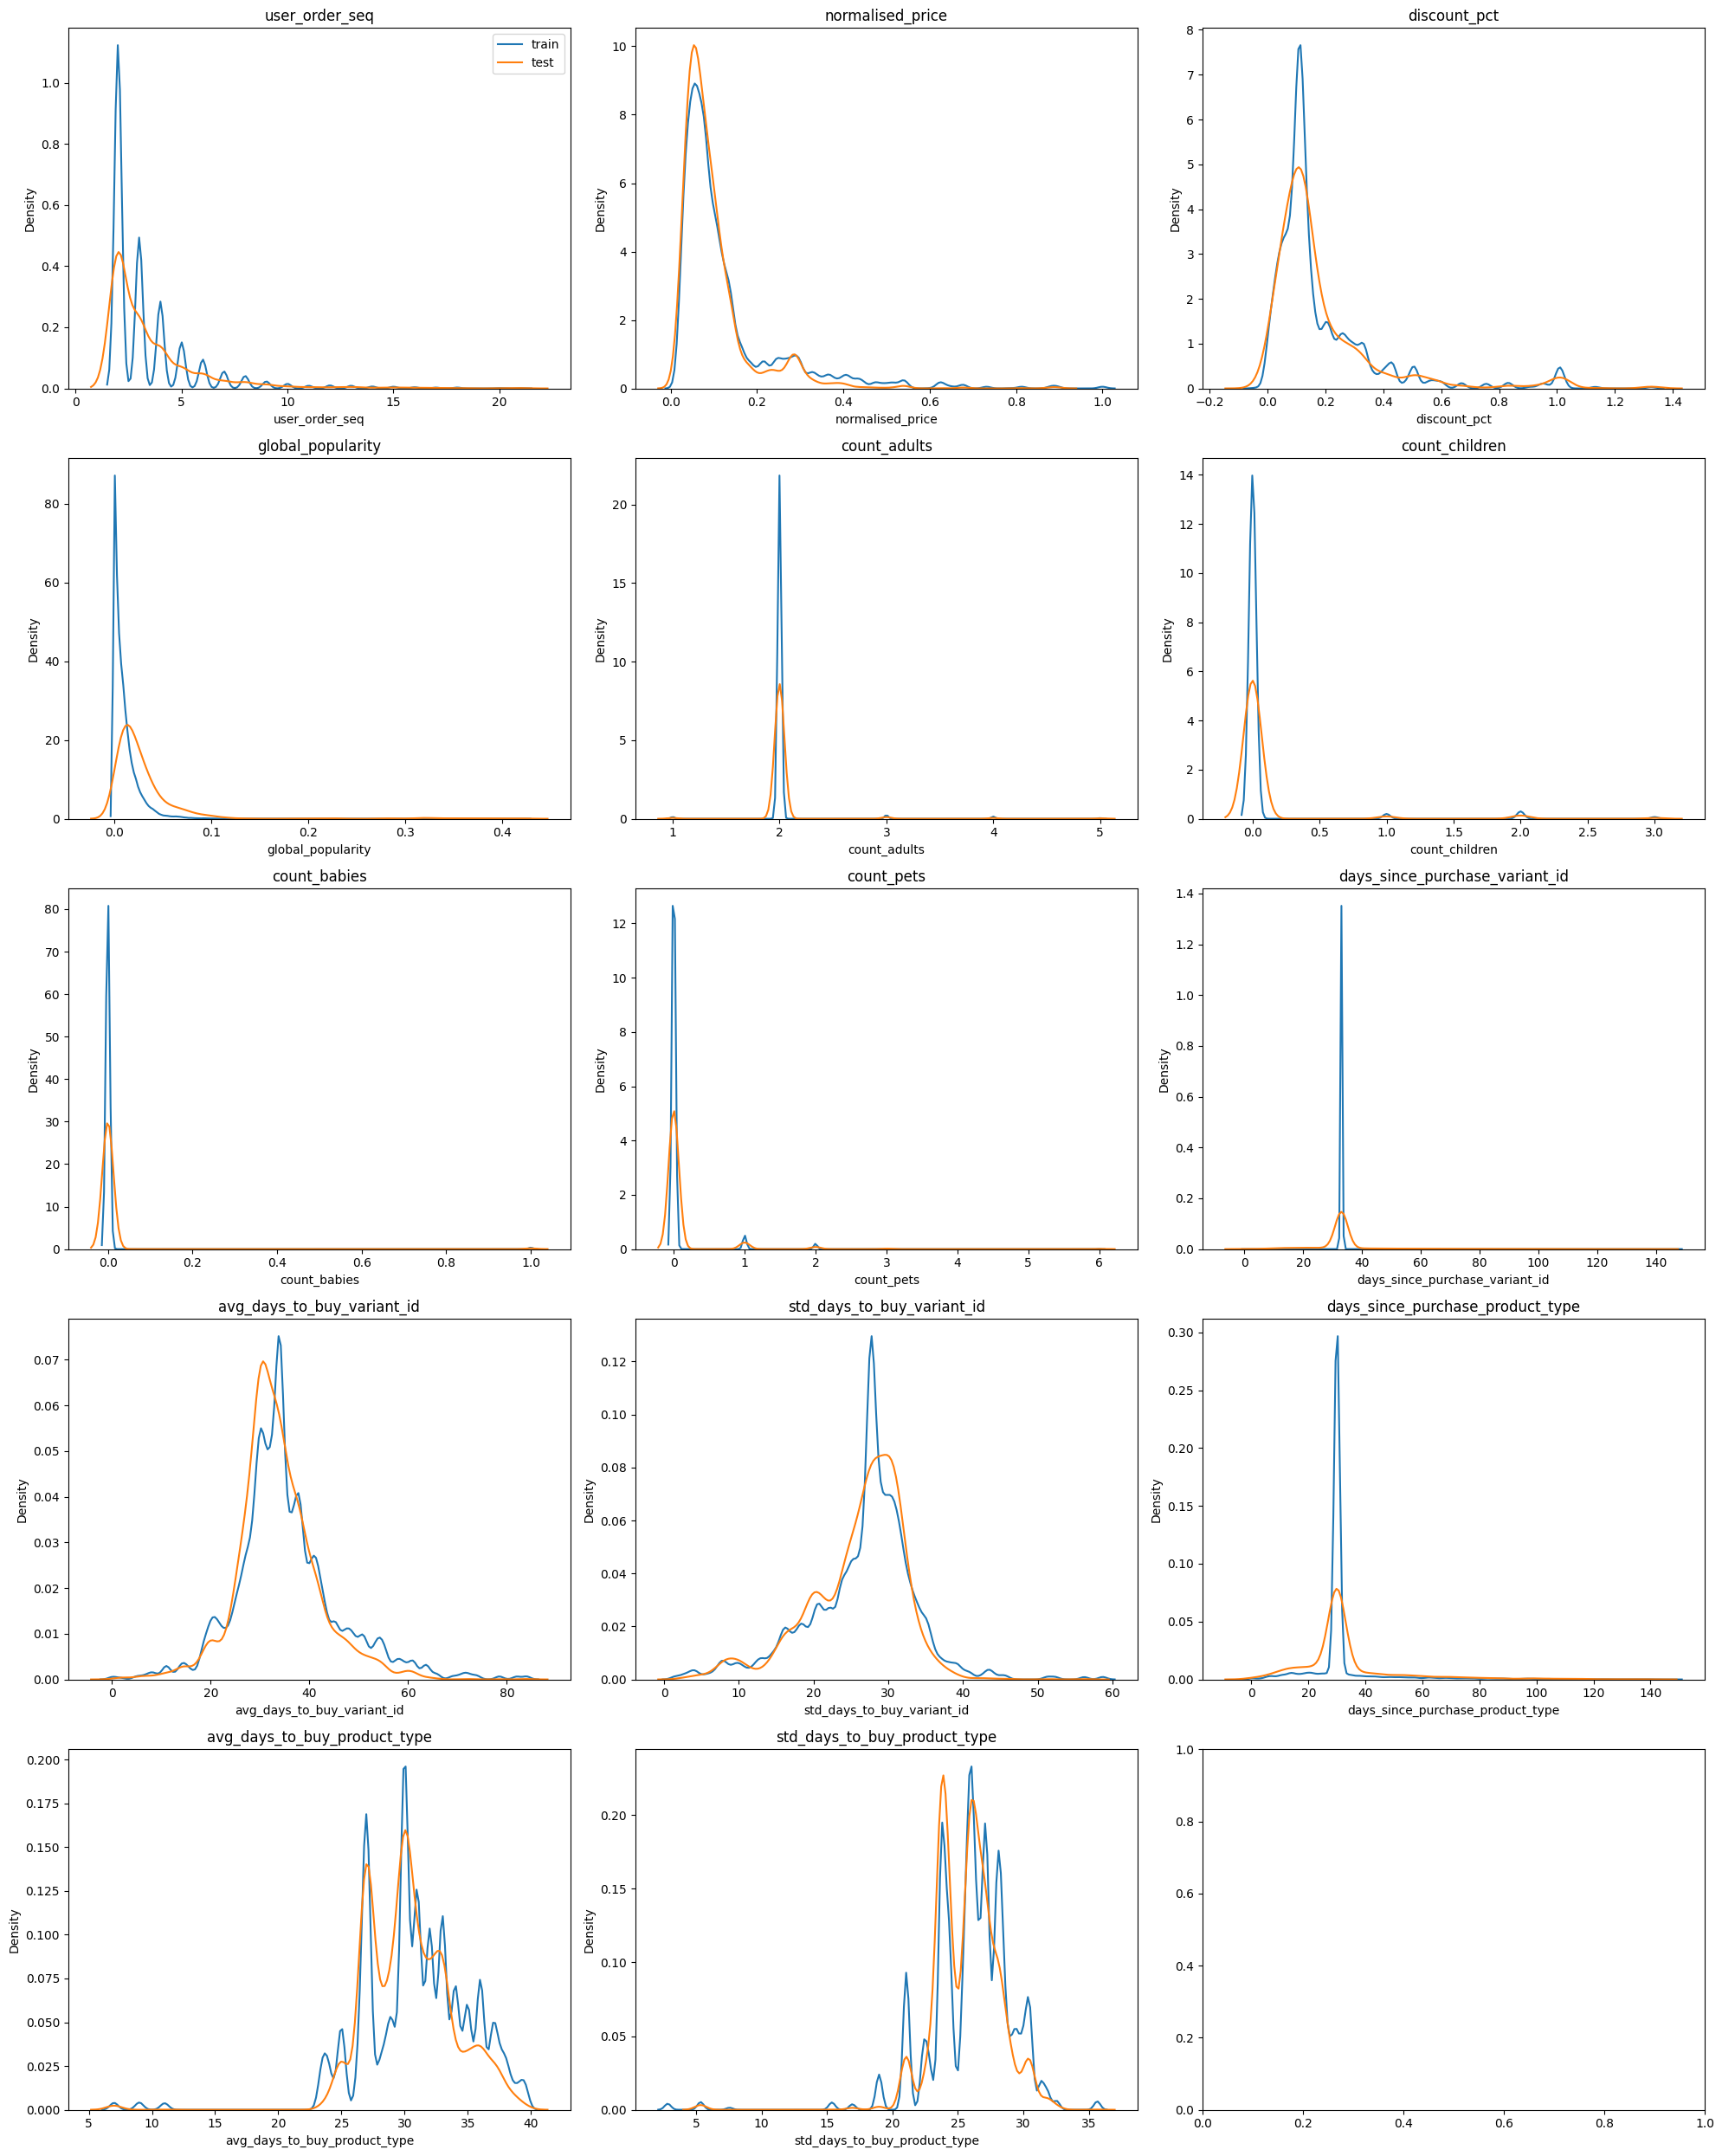

In [14]:

dfs = [df_train, df_test]

for df in dfs:
    cols = 3
    rows = int(np.ceil(len(numerical_cols) / cols))
    fig, ax = plt.subplots(rows, cols, figsize=(20, 5*rows))
    ax = ax.flatten()

    for i, col in enumerate(numerical_cols):
        sns.kdeplot(df.loc[lambda x: x.outcome == 0, col], label='train', ax=ax[i])
        sns.kdeplot(df.loc[lambda x: x.outcome == 1, col], label='test', ax=ax[i])
        ax[i].set_title(col)
        
    ax[0].legend()

    plt.tight_layout()

In [23]:
df_train.groupby("outcome").mean()

In [19]:
df[numerical_cols].head()

: 

TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

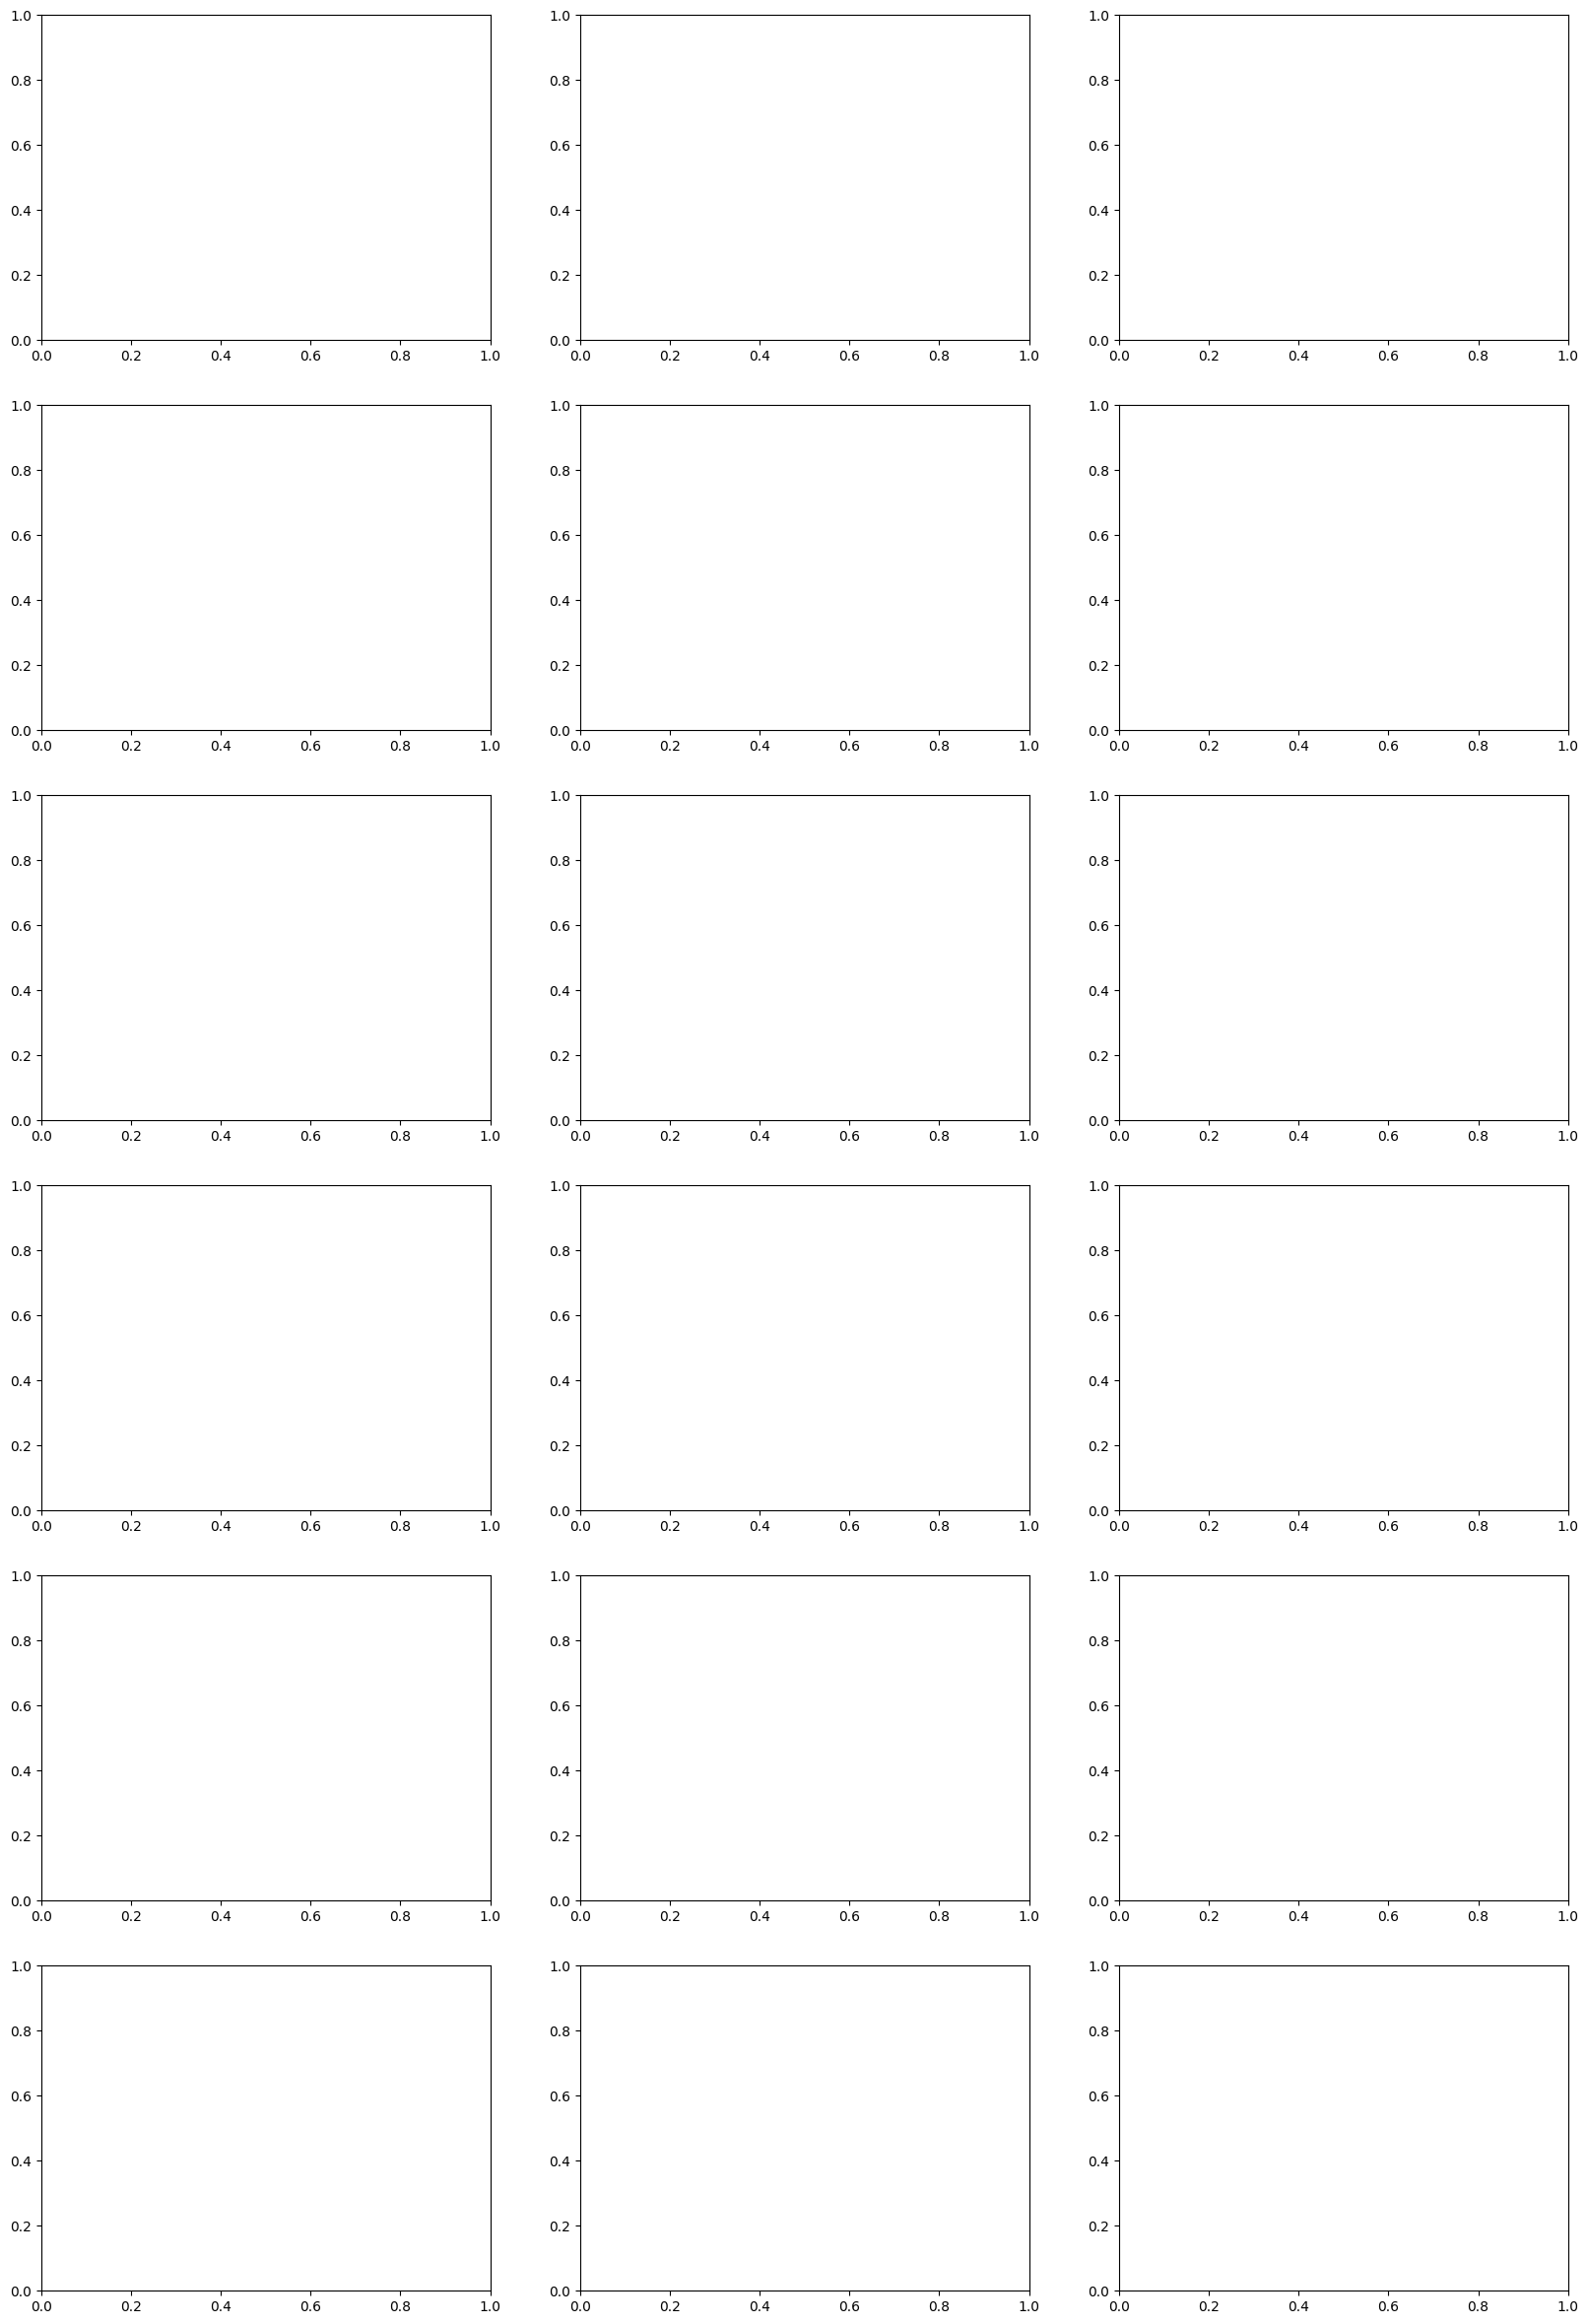

In [11]:
cols = 3
rows = int(np.ceil(len(numerical_cols) / cols))
fig, ax = plt.subplots(rows, cols, figsize=(20, 5*rows))
ax = ax.flatten()

for i, col in enumerate(numerical_cols):
    sns.kdeplot(df_train.loc[lambda x: x.outcome == 0, col], label='0', ax=ax[i])
    sns.kdeplot(df_train.loc[lambda x: x.outcome == 1, col], label='1', ax=ax[i])
    ax[i].set_title(col)
    
ax[0].legend()

plt.tight_layout()

In [6]:
df_test, df_validation = train_test_split(test, test_size=0.5, stratify=df_work.order_id)


ValueError: Found input variables with inconsistent numbers of samples: [432791, 2163953]

In [43]:
train.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_babies,count_pets,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,product_type_encoded,vendor_encoded
239225,33826427502724,cookingingredientsoils,2869681127556,3820142788740,2020-12-11 09:45:23,2020-12-11 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,33.0,39.0,31.727619,32.0,31.0,27.135844,0.038385,0.051212
1552017,34460976414852,dental,2895188983940,3781485789316,2021-01-12 09:48:51,2021-01-12 00:00:00,5,0.0,0.0,0.0,...,0.0,0.0,33.0,29.0,12.733243,54.0,33.0,27.935275,0.022422,0.005585
1734022,33881379668100,shavinggrooming,2922904748164,3913643884676,2021-02-15 21:04:54,2021-02-15 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,33.0,48.0,30.701972,30.0,35.0,27.143111,0.015014,0.014737
2043873,33667174498436,handsoapsanitisers,2904720146564,3817296461956,2021-01-24 17:50:00,2021-01-24 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,33.0,36.0,23.924380,30.0,33.0,27.961179,0.020018,0.013232
729370,34543001927812,cleaningaccessories,3643226718340,3929955500164,2021-03-03 12:32:48,2021-03-03 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,33.0,34.0,27.693045,30.0,35.0,29.001400,0.017485,0.000464


In [21]:
df_work[(df_work["count_adults"] + df_work["count_children"] ) !=  df_work["people_ex_baby"]].head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,product_type_encoded,vendor_encoded


In [4]:
# df[df["order_id"]==2807985930372].to_csv("order_sample.txt", sep="\t")
# #df[df["user_id"]==3482464092292].to_csv("user sample.txt", sep="\t")
# # df[df["variant_id"]==33826472919172]

# # df = df.head(1000)
# df.info()

In [1]:

df_work.head()


NameError: name 'df_work' is not defined

In [32]:
len()

2795

In [14]:
df_filter.sort_values(by="variant_i")

,order_id,variant_id,product_type,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,2807985930372,608,608,608,608,608,608,608,608,608,...,608,608,608,608,608,608,608,608,608,608
1,2808027644036,608,608,608,608,608,608,608,608,608,...,608,608,608,608,608,608,608,608,608,608
2,2808099078276,608,608,608,608,608,608,608,608,608,...,608,608,608,608,608,608,608,608,608,608
3,2808393957508,611,611,611,611,611,611,611,611,611,...,611,611,611,611,611,611,611,611,611,611
4,2808429314180,614,614,614,614,614,614,614,614,614,...,614,614,614,614,614,614,614,614,614,614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3422,3642900349060,976,976,976,976,976,976,976,976,976,...,976,976,976,976,976,976,976,976,976,976
3421,3642856079492,976,976,976,976,976,976,976,976,976,...,976,976,976,976,976,976,976,976,976,976
3444,3643294515332,976,976,976,976,976,976,976,976,976,...,976,976,976,976,976,976,976,976,976,976
3432,3643189461124,976,976,976,976,976,976,976,976,976,...,976,976,976,976,976,976,976,976,976,976
